# Make your own mock data and write your own MCMC

Aim: Understand and write a simple MCMC code that can sample a likelihood surface, then plot results. 

In [4]:
# Import your libraries:

# Genral imports
import numpy as np

# Plotting imports
import matplotlib.pylab as plt
from chainconsumer import ChainConsumer
from matplotlib import colors as mcolors

In [5]:
# Lets make a list of nice colours for plotting.
# If you uncomment the print statement you can see the full list of colour names and define your own.

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]
# print(sorted_names)

# pick the colours that you want
orange = colors['darkorange']
pink   = colors['hotpink']
blue   = colors['darkturquoise']


## A: Create a data vector

First step of the assignment is to create a toy data vector. We start by using this simple function. You can play with other functions later. 

In [6]:
# A simple function with two variables
def mockdata(x,a,b):
    return a*np.log10(x)+b

Now define 9 $x$ values between 0.5 and 300.0 in log10 space. We are going to set $a$ and $b$ to the values below for now. 

In [7]:
# Define 9 x values between 0.5 and 300 in logspace

xmin = 0.5
xmax = 300.0
nx   = 9
x = np.logspace(np.log10(xmin), np.log10(xmax), nx)

# Set the input a and b values
a = 0.75
b = 0.3

# Create a mock data vector,call it y_th using the simple function: mockdata for the above x values 
y_th = mockdata(x,a,b)

Now plot your theoretical mock data vector using matplotlib

Text(0, 0.5, 'y')

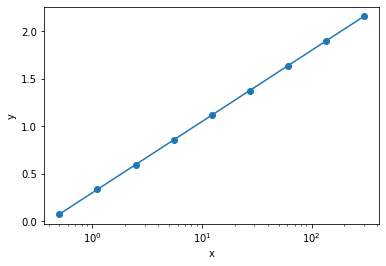

In [8]:
# plot y_th versus x

plt.xscale('log')
plt.plot(x,y_th,'-o')
plt.xlabel('x')
plt.ylabel('y')

## B: Add noise to mock data
We want to make a data vector that resembles real data. Real data has noise, so lets add noise to our theoretical model. 

### B.1: Add independent noise

For simplicity assume:
1. The error on each data point is independant of the others. 
2. All 1$\sigma$ errors are equal to 1.

Now create a noise realisation by randomly picking from a Gaussian distribution (hint: you can use np.random.normal to do this)


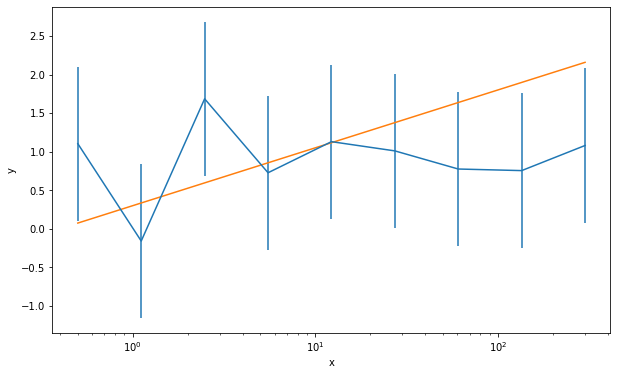

In [9]:
# Create noise realisation Gaussian independent error
sigma = 1.0
noise_realisation = np.random.normal(0.,sigma,nx)



# Add noise to the theoretical data vector
y_data = y_th + noise_realisation

# plot y_th and y_data (with errorbars, hint: you can use plt.errorbar) 

plt.figure(figsize=(10,6))
plt.xscale('log')
plt.errorbar(x,y_data,yerr=sigma)
plt.plot(x,y_th,'-')
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("xy.png")


### B.2: Add correlated noise
In practice the error on our data points may not be independent. Sometimes there is significant correlation between them. Lets define a covariance matrix and create our noise realisation from a multivariate Gaussian distribution. You can use np.random.multivariate_normal, but I recommend using a cholesky decomposition in combination with the method in B.1 to gain some understanding of how this works.

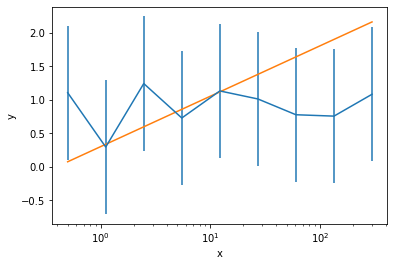

In [10]:
# Here is your starting covariance matrix. We still have one along the diagonals, 
# which is the same as what we had in B.1. But now we have a few non-zero off-diagonals.

cov = np.array([[1., 0.4, 0., 0., 0., 0., 0., 0., 0.],
                [0.4, 1., 0.5, 0., 0., 0., 0., 0., 0.],
                [0., 0.5, 1., 0., 0., 0., 0., 0., 0.],
                [0., 0., 0., 1., 0., 0., 0., 0., 0.],
                [0., 0., 0., 0., 1., 0., 0., 0., 0.],
                [0., 0., 0., 0., 0., 1., 0., 0., 0.],
                [0., 0., 0., 0., 0., 0., 1., 0., 0.],
                [0., 0., 0., 0., 0., 0., 0., 1., 0.],
                [0., 0., 0., 0., 0., 0., 0., 0., 1.]])


# Create a noise realisation using this covariance. 
# look up the cholesky decomposition and use the two line solution (hint: use np.linalg.cholesky)
cholesky_mat = np.linalg.cholesky(cov)
correlated_noise_realisation =  np.dot(cholesky_mat,noise_realisation)


# Add noise to y_th
y_data = y_th + correlated_noise_realisation

# plot y_data and y_th again
plt.xscale('log')
plt.errorbar(x,y_data,yerr=sigma)
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x,y_th,'-')


## C: Fit the model to the data

In this example we know the true model and the value of its parameters (we defined it ourselves!). In reality we won't know that. So for now lets forget that we already have this information and try to find a fit to our data.


### C.1: Define $\chi^2$

The $\chi^2$ function for a general case is 

\begin{equation}
\chi^2=\sum_{i,j}^{N}[y_i-\mu_i(\Phi)](C^{-1})_{ij}[y_j-\mu_j(\Phi)]\;,
\end{equation}

where $\mu_i$ are the expected values of the observables, $y_i$, 
and $C^{-1}$ is the inverse covariance matrix. 
The $\chi^2$ fitting is a generalized (weighted) form of least-square fitting.
To see why notice that if the covariance is a diagonal matrix with equal diagonal components , 
$\sigma^2$ (like we had in B.1), the simple least-square formula is attained,

\begin{equation}
 \chi^2_\mathrm{simple}=\frac{1}{\sigma^2}\sum_{i}^{N}[y_i-\mu_i(\Phi)]^2\;,
\end{equation}

and minimizing this simplified $\chi^2$ results in finding the best fitting values.

Notice that the general definition can be simplied using matrix multiplication:

\begin{equation}
\chi^2=\Delta \mathbf{y}\; C^{-1}\; \Delta \mathbf{y}^t \;,
\end{equation}

where $\Delta \mathbf{y} = \mathbf{y}-\mathbf{\mu}$ is a vector.

In [11]:
# define a chi^2 function based on the last equation above.
def chisq_func(y_data,y_th,cov):
    delta_y = y_data - y_th
    chisq = np.dot(delta_y,np.dot(np.linalg.inv(cov),np.transpose(delta_y)))
    return chisq


Now find the $\chi^2$ value for your mock noisy data. 

In [12]:
chisq = chisq_func(y_data,y_th,cov)
print(chisq)

5.853152016221397


## C.2: Likelihood function

We usually assume that our likelihood function is a (multivariate-) Gaussian. In this case it is fully defined by our $\chi^2$ value. In fact we don't need to define anything else to start sampling the likelihood. 

A multivariate Gaussian distribution for $\mathbf{y}$ has the following form:

\begin{equation}
\label{likelihood}
L(\boldsymbol{\mu}(\Phi)|\mathbf{y})=\frac{\mathrm{e}^{-\chi^2/2}}{(2\pi)^{N/2}\sqrt{\det C}}\;,
\end{equation}

where $N$ is the number of data points.
The likelihood in general will not be Gaussian in parameter space. 
Nevertheless, it is conventional and benign to assume Gaussianity 
near the maximum of the likelihood in most realistic cases. 

We also define the log-likelihood function, $\mathfrak{L}$, as follows:

\begin{equation}
2\mathfrak{L}(\boldsymbol{\mu}(\Phi)|\mathbf{y}) = 
\ln (\det C)+ N\ln(2\pi) + (\mathbf{y}-\boldsymbol{\mu}(\Phi))^\mathrm{T}C^{-1}
(\mathbf{y}-\boldsymbol{\mu}(\Phi))\;.
\end{equation} 


## C.3: MCMC, Monte Carlo Markov Chain


A Markov chain is a random process where each state (point) in the chain depends only on the previous one. 
For an MCMC chain we need to first pick a start point, $\phi_{\rm start}$. 
Then the next point, $\phi_{\rm prop}$, is chosen from a proposal distribution, 
$P(\phi_{\rm prop}|\phi_{\rm start})$ which depends on the start point. 
The proposal distribution can have any functional 
form and generally can be asymmetric.

When the general form of the likelihood distribution is not known beforehand,
a practical choice for the proposal distribution is a multivariate Gaussian distribution with the 
Fisher matrix as the inverse covariance matrix.

After picking a point randomly from the proposal distribution its likelihood is compared to the 
likelihood of the start point. If it is higher then the proposed point is added to the chain, 
however, a lower likelihood does not automatically exclude the new point. 
Instead it is accepted by a probability of 

\begin{equation}
 P(\rm acceptance)= \frac{L(\phi_{\rm prop})P(\phi_{\rm prop}|\phi_{\rm start})}
 {L(\phi_{\rm start})P(\phi_{\rm start}|\phi_{\rm prop})}\;,
\end{equation}

where $L(\phi)$ is the likelihood of the data belonging to the model with parameters $\phi$. 
For simplicity most proposal distributions take a symmetric form, i.e. 
$P(\phi_{\rm prop}|\phi_{\rm start})=P(\phi_{\rm start}|\phi_{\rm prop})$.
In this case the acceptance probability reduces to the ratio of the likelihood of the proposed point
to the start point. If the proposed point is not accepted the start point is repeated in the chain. 
This process is repeated with each point, that is added to the chain, as the new start point. 

If the start point of a chain is outside the high likelihood volume a number of steps are needed 
for the chain to burn into this volume. These burn in points need to be excluded from the analysis, 
since they depend on the choice of the start point rather than the likelihood itself. 
Typically, a visual inspection is sufficient for finding the burn in chain. 


### Now create a step by step algorithm (in writting first) 

1. Choose a starting position in your parameter space (a_start and b_start)
2. Define a proposal distribution (you can use Fisher matrixes or a previous run to guide you)
3. Calculate chi^2 value for these starting values
4. Pick a new set of parameter values randomly from the proposal distribution (this is your proposed new point to add to the chain)
5. Calculate chi^2 for this new set of parameters
6. Compare the new chi^2 with the one from the previous step
    + use the ratio of chi^2 values
    + if chi^2_i>chi^2_i+1 choose the new value 
    + if chi^2_i<chi^2_i+1 choose the new value with this probability: np.exp(-0.5*(chis_prop-chis_phi))
7. If the proposed point is accepted then add it to the chain, if not add the current point (step i)
8. Repeat from point 3
9. Once you have your chain, remember to burn in the starting values. 

### C.4: Create your proposal distribution

Now that you have itemised the steps, you can write your own MCMC code! To create the proposal lets use the recommended approach of using a Fisher matrix. 

### What is a Fisher Matrix?

Consider a model with a number of parameters, $\phi_j$, 
and a data set with a number of data points, $y_i$, 
then Fisher analysis determines the amount of information contained in the data set, 
$y_i$, about the parameters, $\phi_j$, assuming that the likelihood is Gaussian. 
In general this assumption is satisfied near the maximum of the likelihood function. 
Another way of looking at the Fisher matrix is to acknowledge 
its close relation to the covariance matrix of the model parameters; 
in this sense Fisher matrix analysis is a compact way of propagating 
errors from the observable, to the parameter space.

Formally, the Fisher matrix is defined as the ensemble average of second derivatives 
of log-likelihood function at the maximum likelihood point,

\begin{equation}
\label{fisher}
F_{ij}\equiv \bigg\langle\frac{\partial^2 \mathfrak{L}}{\partial \phi_i \: \partial \phi_j} 
\bigg\rangle\;
\end{equation}

To make the connection between this definition and the meaning of Fisher matrix explained above 
let us consider the Taylor expansion of $\mathfrak{L}_{,\phi_i}$, where $_{,\phi_i}$ denotes a partial derivate with respect to the parameter $\phi_i$,

\begin{equation}
\mathfrak{L}_{,\phi_i}(\bar{\Phi}|\mathbf{x})
=\mathfrak{L}_{,\phi_i}(\Phi^{(0)}|\mathbf{x})+\sum_j\mathfrak{L}_{,\phi_i\phi_j}
(\Phi^{(0)}|\mathbf{x})(\bar{\phi}_j-\phi^{(0)}_j)+...\;,
%=\mathfrak{L}_{,\phi_i}(\Phi^{(0)})+\mathrm{D}\mathfrak{L}_{,\phi_i}(\Phi^{(0)})\:.(\bar{\Phi}-\Phi^{(0)})+...\;,
\end{equation} 

The second term in this expansion contains the curvature matrix of the log-likelihood function,
$\mathrm{D}^2\mathfrak{L}$, which is a measure of how fast the likelihood function 
drops near its maximum and the Fisher matrix is the expectation value of this curvature.

To calculate the Fisher matrix one does not need to find the likelihood function, 
instead by considering the derivatives of $\mathfrak{L}$ and their expectation value the following analytical formula is found,

\begin{align}
\label{FisherTeg}
F_{ij}=\langle \mathfrak{L}_{,ij} \rangle = \frac{\partial \mathbf{y}}{\partial \phi_{i}} \:C^{-1}\: \frac{\partial \mathbf{y}}{\partial \phi_{j}},
\end{align}

where we have assumed that the covariance matrix doesn't vary (significantly) with parameters.
From this equations we can see that a model with 2 parameters (like our starting mockdata functions) will have a $2\times2$ Fisher matrix. Note that the Fisher matrix is always symmetric.

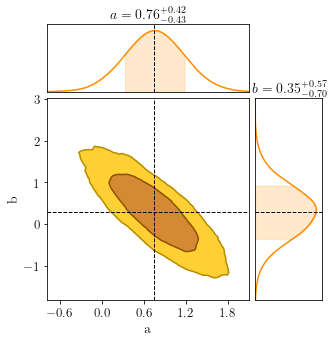

In [13]:
# Create a multivariate Guassian distribution as your proposal distribution

# Use the last equation above to estimate your Fisher matrix.
# You will need to calculate the derivates of y with respect to your model parameters. 
# You can write a general function that calculates derivates for any input function.
# Or for now write a specific function for your case.


# This is specific to our case. Write a more general version that accpts any function. 
def der(x,a,b):
    der=[]
    #derivative with respect to a:
    der.append(np.log10(x))
    #derivative with respect to b:
    der.append(np.ones(len(x)))
    return np.transpose(np.asarray(der))

# Define your Fisher matrix
def Fisher(derivative,cov):
    return np.dot(np.transpose(derivative),np.dot(np.linalg.inv(cov),derivative))

# Calculate your Fisher matrix
# write a generalisaed derivative function
derivative = der(x,a,b)
Fisher_mat = Fisher(derivative,cov)


# Create your proposal distribution and plot it using chainconsumer: https://samreay.github.io/ChainConsumer/ 
cov_param = np.linalg.inv(Fisher_mat)

a_start = a
b_start = b

mu = np.array([a_start,b_start])
# Create a multivariate Guassian distribution
proposal = np.random.multivariate_normal(mu, cov_param,size=10000)



# Example plotting code snippet
from chainconsumer import ChainConsumer
# plot the proposal distribution
c = ChainConsumer()
c.add_chain(proposal,color=orange ,parameters=['a','b'], kde=1.0,shade=True,name=r"Proposal",shade_alpha=0.8)
c.configure(plot_hists=True,shade_gradient=1.0,diagonal_tick_labels=False,label_font_size=14,tick_font_size=13,serif=True,legend_color_text=True,linewidths=1.5,statistics="max")
c.plotter.plot(filename="proposal.png", figsize=1.5, truth=[a,b])
plt.show()

### C.5: Create your chain and plot the results

Now that you have your proposal distribution defined, go through the steps that you have identified above and write your MCMC code. You need to also tell it when to stop. For now lets use a variable called "nSteps" to set a fixed number of steps after which we stop the chain. How does this number and your starting parameter values effect the results?

In [15]:
# Create your MCMC code and run it on y_data
a_start = 1.0
b_start = 0.1

phi = np.array([a_start,b_start])
y_phi = mockdata(x,phi[0],phi[1])
chis_phi = chisq_func(y_data,y_phi,cov)

import random
nSteps = 100000
chain=[]
chain_entry = list(phi)
chain_entry.append(chis_phi)
chain.append(chain_entry)
for s in range(nSteps):
    phi_prop = np.random.multivariate_normal(phi, cov_param)
    y_prop = mockdata(x,phi_prop[0],phi_prop[1])
    chis_prop = chisq_func(y_data,y_prop,cov)
    Ratio = np.exp(-0.5*(chis_prop-chis_phi))
#     number ratio=exp(-0.5*(chi2-chi1));
#     print(phi,phi_prop)
    if Ratio>1:
#         print(Ratio,chis_phi,chis_prop)
        #accept the proposed point in the chain
        chis_phi = chis_prop
        phi = phi_prop
    else:
        #use ratio to decide which one to accept
#         print(Ratio,chis_phi,chis_prop)
        accepted_phi = random.choices([phi,phi_prop], weights = [1,Ratio])
        if (accepted_phi == phi_prop).all():
            chis_phi = chis_prop
            phi = phi_prop
#         print('Ratio=',Ratio,' accepted phi is ',accepted_phi)
    chain_entry = list(phi)
    chain_entry.append(chis_phi)
    chain.append(chain_entry)
    
chain_arr = np.asarray(chain)

Now plot your results, use the example given in the proposal section.

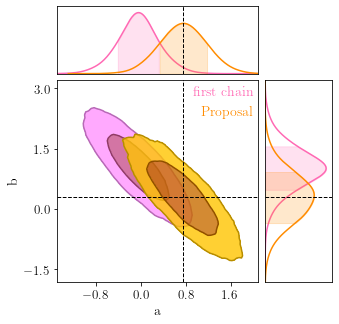

In [16]:
# use chainconsumer to plot your chain
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_chain(chain_arr[:,[0,1]],color=pink ,parameters=['a','b'], kde=1.5,shade=True,name=r"first chain",shade_alpha=0.8)
c.add_chain(proposal,color=orange ,parameters=['a','b'], kde=1.0,shade=True,name=r"Proposal",shade_alpha=0.8)
c.configure(plot_hists=True,shade_gradient=1.0,diagonal_tick_labels=False,label_font_size=14,tick_font_size=13,serif=True,legend_color_text=True,linewidths=1.5,statistics="max")
c.plotter.plot(filename="mcmc.png", figsize=1.5, truth=[a,b])
plt.show()

## D: Extras!

Congradulations! You have written a working MCMC code (if not go back and try to finish that before continuing). Here are a list of other things to do and think about:

1. You saw that we need to tell the chain when to stop. How do we know if the results are stable? This is usually a question of convergence: has my chain converged to something close to the true likelihood distribution? There are a few method for testing convergence. Some are already coded in chainconsumer. Look for them and use them on your chain.
2. We haven't talked about burn-in. Depending on where you set your starting point you'll need a different burn-in. Plot your chain steps to get an idea of where that should be. Try different starting points.
3. We used a noisy data vector for our test and you might have noticed that the middle of your contours doesn't quite sit on top of the "True" values for $a$ and $b$. What if you were to run this chain on the different noise realisation? Think: What would happen if you made many noise realisation and looked at all of their results? How would the contour look like?
3. What would happen if you ran the chain on a noiseless data vector, $y_th$?
4. We have a very simple model with only two parameters. Our data vector is also linearly dependent on the parameters. What happens if you generalise the model? 
5. Have you compared your proposal distribution with your chain result? Does it matter what kind of model you have?
6. One of our aims when analysing data is to find the best fitting parameters and model. Can you modify your MCMC code so that it finds this value? 
7. Plot your chains and bestfit values. Compare them to your input values. 
8. We haven't touched on priors. How would you incorporate priors in your algorithm? 